# Beginning Imports

In [1]:
# INSTALLS
!pip3 install pathlib
!pip3 install saxonche
!pip3 install pandas
!pip3 install networkx
!pip3 install pyvis

In [2]:
# IMPORTS for the text NLP processing
import pathlib
import spacy
from pathlib import Path
from saxonche import PySaxonProcessor
from collections import Counter

In [3]:
# IMPORTS For the network visualizations
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

In [4]:
# nlp = spacy.cli.download("en_core_web_lg")
# ONLY NEED ABOVE LINE ONCE. REMEMBER: COMMENT OUT THE ABOVE LINE THE NEXT TIME YOU RUN THIS.
nlp = spacy.load('en_core_web_lg')

# Directing file paths and gathering text

In [5]:
InputPath = 'lyricXML'
OutputPath = 'lyricOutput' 

In [6]:
def xqueryAndNLP(InputPath):
    # This time, let's try XQuery over a collection of files:
    with PySaxonProcessor(license=False) as proc:
        print(proc.version)
        xq = proc.new_xquery_processor()
        xq.set_query_base_uri(Path('.').absolute().as_uri() + '/')
        xq.set_query_content('''
let $allTheLyrics := collection('lyricXML/.?select=*.xml;recurse=yes')
(: ebb: our collection variable is set to recurse through the internal nested folders. :)
let $lines := $allTheLyrics//l ! text()
return string-join($lines, ' ')

''')
        r = xq.run_query_to_string()
        # print(r)
        r = str(r)
    return r

xqueryAndNLP(InputPath)

SaxonC-HE 12.4.2 from Saxonica


'<?xml version="1.0" encoding="UTF-8"?>Lips meet teeth and tongue My heart skips eight beats at once If we were meant to be, we would have been by now See what you wanna see, but all I see is him right now I\'ll sit and watch your car burn With the fire that you started in me But you never came back to ask it out Go ahead and watch my heart burn With the fire that you started in me But I\'ll never let you back to put it out Your love feels so fake And my demands aren\'t high to make If I could get to sleep, I would have slept by now Your lies will never keep, I think you need to blow \'em out I\'ll sit and watch your car burn With the fire that you started in me But you never came back to ask it out Go ahead and watch my heart burn With the fire that you started in me But I\'ll never let you back to put it out When you call my name Do you think I\'ll come runnin\'? You never did the same So good at givin\' me nothin\' When you close your eyes, do you picture me? When you fantasize, am 

# Spacy and NLP 

In [ ]:
inputstring = xqueryAndNLP(InputPath)

# start playing with spaCy and nlp:
words = nlp(inputstring)
# print(words)

# Collecting the lemmatized forms will be better than just all the words. (Remember what these are?)
Lemmas = []
for token in words:
    if token.pos_ == "NOUN":
        lemma = token.lemma_
        Lemmas.append(lemma)

# Okay, we'll use python's Counter() find out how frequently each verb lemma shows up in the entire verb list.
# Counter() removes duplicates and counts the number of times something appears. 
# And it outputs a dictionary of key:value pairs already sorted from highest to lowet count.

# print(Lemmas)

lemmaFreq = Counter(Lemmas)
totalLemmaCount = len(lemmaFreq) 

print(f"Lemma count: {totalLemmaCount}")

print(f"Lemma frequency {lemmaFreq}")

#### Interesting to see 'time' as the most used word amongst all the artists

# Choosing how many values(words) to look at

In [ ]:
# As with our previous bar graph examples in exercise 3, we don't want to plot every last word here.
# But we have a lot of data, so we can experiment!
# To access data in our Counter list and keep it organized from highest to lowest value, we use `most_common()`.
# Then we can slice it to store however many we want to plot. [:10] would plot the first 11 values since python starts counting from zero.

mostCommon = dict(lemmaFreq.most_common()[:29])
print(f"mostCommon Lemmas {mostCommon}")

# Here we are unpacking our sliced dictionary of most common noun lemmas into lists of the values and keys,
# and checking to make sure they remain in their dictionary order here. 
# We will use the list of lemmas in the next code cell to look for each one as used by each artist.  
# (We used them when plotting bar graphs, 
# so you could output some bar graphs in the next cells if you want, and then return to the network we're building!

listCounts = list(mostCommon.values())
listLems = list(mostCommon.keys())
print(f"listCounts: {listCounts}")
print(f"listLems: {listLems}")


# Organizing into syntax and counts

In [ ]:
def networkQuery(listLems, InputPath):
    with PySaxonProcessor(license=False) as proc:
       for lemma in listLems:
            xq = proc.new_xquery_processor()
            xq.set_query_base_uri(Path('.').absolute().as_uri() + '/')
            xquery = f'''
                declare variable $lemma as xs:string* external := '{lemma}';
                declare variable $string as xs:string := string-join(
                let $billieLyrics := collection('lyricXML/billie/.?select=*.xml;recurse=yes')
                let $allTheLyrics := collection('lyricXML/.?select=*.xml;recurse=yes')
                (: ebb: our collection variables are set to recurse through the internal nested folders.:)
                
                let $artistNames := ('billie', 'olivia', 'sabrina', 'taylor')
                for $name in $artistNames
                (: return $name :) 
                
                let $lemmaLines := $allTheLyrics[base-uri() ! substring-after(.,'oliviarodrigo/lyricNotebook/lyricXML/') ! contains(., $name)]//l ! text()[contains(., $lemma)]
                let $billieCount := count($lemmaLines)
                return ($lemma || '\t' || 'used by' || '\t' || $name || '\t' ||  $billieCount), '\n');
                
                (: May work more reliably than regex '\n' :)
                (: IF NEEDED: in place of \t, we can use `&#x9;.` :)
                (: IF NEEDED: in pace of \n, we can use this weird special character for a newline or hard return.:)
                $string
            '''
            xq.set_query_content(xquery)
        
    
            r = xq.run_query_to_value()
            r = str(r)
            print(r)

    return r
    
networkQuery(listLems, InputPath)   
    

#### Output is getting an oddly high number for olivia words; I am not sure what is doing this...

# Organizing into a chart

In [ ]:
from io import StringIO
OutputPath = 'lyricOutput/networkdata.tsv' 

def networkQuery(listLems, InputPath):
    listdfs = []
    with PySaxonProcessor(license=False) as proc:
       for lemma in listLems:
            xq = proc.new_xquery_processor()
            xq.set_query_base_uri(Path('.').absolute().as_uri() + '/')
            xquery = f'''
                declare variable $lemma as xs:string* external := '{lemma}';
                declare variable $string as xs:string := string-join(
                let $billieLyrics := collection('lyricXML/billie/.?select=*.xml;recurse=yes')
                let $allTheLyrics := collection('lyricXML/.?select=*.xml;recurse=yes')
                (: ebb: our collection variables are set to recurse through the internal nested folders.:)
                
                let $artistNames := ('billie', 'olivia', 'sabrina', 'taylor')
                    for $name in $artistNames
                    (: return $name :) 
                
                    let $lemmaLines := $allTheLyrics[base-uri() ! substring-after(.,'oliviarodrigo/lyricNotebook/lyricXML/') ! contains(., $name)]//l ! text()[contains(., $lemma)]
                    let $billieCount := count($lemmaLines)
                    return ($lemma || '\t' || 'used by' || '\t' || $name || '\t' ||  $billieCount), '\n');
                
                (: May work more reliably than regex '\n' :)
                (: IF NEEDED: in place of \t, we can use `&#x9;.` :)
                (: IF NEEDED: in pace of \n, we can use this weird special character for a newline or hard return.:)
                $string
            '''
            xq.set_query_content(xquery)
        
            r = xq.run_query_to_value()
            r = str(r)
            # print(r)
            # ebb: Now we read this into a pandas dataframe based on tab-separated values as csv/tsv data:
            df = pd.read_csv(StringIO(r), header=None, sep="\t")
            # print(df) # ebb: This churns out lots of little dataframes based on each turn of the python for loop in this function.
            # So, we need to bundle them together. We'll start by putting them in a list. 
            listdfs.append(df)
            # print(listdfs)
    # ebb: Now we concatenate the list of pandas dataframes into just one using pd.concat:
    merged_df = pd.concat(listdfs, ignore_index=True)
    merged_df.to_csv(OutputPath, sep="\t") 
           

    return(merged_df)
    
networkQuery(listLems, InputPath)

# Trying out a graph

In [ ]:
networkData = networkQuery(listLems, InputPath)   

# Create the network graph
net = Network(height='600px', width='100%', bgcolor='#222222', font_color='black', notebook=True, select_menu=True, cdn_resources="in_line")


# Iterate through the DataFrame and add nodes and edges
for i, row in networkData.iterrows():
    source = row[0]
    target = row[2]
    weight = row[3]
    net.add_node(source, shape='box', color='red')
    net.add_node(target, shape='ellipse', color='purple')
    net.add_edge(source, target, value=weight*20, title=weight)


# Customize the layout
# ebb: see PyVis docs: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.barnes_hut
# I'm trying out / commenting out various combinations of network properties here:
# net.barnes_hut()
net.barnes_hut(gravity=-80000, central_gravity=0.003, spring_length=5, spring_strength=.1, damping=0.5, overlap=0)

# print(net)
# Display the graph in the Jupyter Notebook
net.show_buttons(filter_=['physics'])
net.show('network_graph.html')

In [ ]:
### ebb: UNDER CONSTRUCTION! 
networkData = networkQuery(listLems, InputPath)   

# Create the network graph
G = nx.Graph()


# Iterate through the DataFrame and add nodes and edges
for i, row in networkData.iterrows():
    source = row[0]
    target = row[2]
    weight = row[3]
    G.add_node(source, shape='box')
    G.add_node(target, shape='ellipse')
    if target == "billie":
        colorEdge = "blue"
    elif target == "olivia": 
        colorEdge = "purple"
    elif target == "sabrina":
        colorEdge = "magenta"
    elif target == "taylor":
        colorEdge = "red"
    else:
        colorEdge = "coral"
    # How to write Python if else conditions: https://www.w3schools.com/python/python_conditions.asp 
    G.add_edge(source, target, value=weight, title=weight, color=colorEdge)

# Calculate this network's centrality statistics
degree_centrality = nx.degree_centrality(G)
# print(degree_centrality)

closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
eccentricity = nx.eccentricity(G)
print(eccentricity)

# VISUALIZE THE NETWORKX NETWORK IN PYVIS

# Create node size list based on closeness centrality
node_sizes = [v * 100 for v in degree_centrality.values()]
print(node_sizes)

# Generate node colors based on degree or eigenvector centrality
node_colorVals = [c * 20 for c in closeness_centrality.values()]

# Create PyVis Network object
net = Network(height='600px', width='100%', bgcolor='white', font_color='black', notebook=True, select_menu=True, cdn_resources="in_line")


# Add nodes and edges to PyVis Network
for node in G.nodes:
    # print(node, '||', node_sizes[list(G.nodes).index(node)])
    cv = node_colorVals[list(G.nodes).index(node)] * 50
    # ebb: Here we'll try basing the COLOR and SIZE of the nodes based on network calculations. 
    # Follow the code to see which variables store the network information. 
    # We set rgba Red, Green, Blue color values: https://www.w3schools.com/cssref/func_rgba.php
    net.add_node(node, shape=G.nodes[node]['shape'], color=f"rgba({cv}, 255, 255, 0.8)", size=node_sizes[list(G.nodes).index(node)])
# print(list(G.nodes).index(node))

for source, target, edge_data in G.edges(data=True):
    print(edge_data)
    net.add_edge(source, target, value=edge_data['value'], color=edge_data['color'], title=edge_data['title'])
# Show the interactive plot

# print(net)
net.barnes_hut(gravity=-25060, central_gravity=21, spring_length=530, spring_strength=.1, damping=0.09, overlap=0)
# net.force_atlas_2based(gravity=-50, central_gravity=0.01, spring_length=100, spring_strength=0.08, damping=0.4, overlap=0)[source]
net.show_buttons(filter_=['physics'])
net.show('degreeNetworkVis.html')

## Adjusting code to produce adjectives output

In [7]:
inputstring = xqueryAndNLP(InputPath)

# start playing with spaCy and nlp:
words = nlp(inputstring)
# print(words)

# Collecting the lemmatized forms will be better than just all the words. (Remember what these are?)
Lemmas = []
for token in words:
    if token.pos_ == "ADJ":
        lemma = token.lemma_
        Lemmas.append(lemma)

# Okay, we'll use python's Counter() find out how frequently each verb lemma shows up in the entire verb list.
# Counter() removes duplicates and counts the number of times something appears. 
# And it outputs a dictionary of key:value pairs already sorted from highest to lowet count.

# print(Lemmas)

lemmaFreq = Counter(Lemmas)
totalLemmaCount = len(lemmaFreq) 

print(f"Lemma count: {totalLemmaCount}")

print(f"Lemma frequency {lemmaFreq}")

SaxonC-HE 12.4.2 from Saxonica
Lemma count: 499
Lemma frequency Counter({'bad': 134, 'good': 132, 'la': 64, 'well': 48, 'same': 44, 'right': 37, 'more': 37, 'nice': 37, 'alone': 33, 'new': 31, 'sorry': 30, 'wrong': 30, 'happy': 29, 'cool': 27, 'little': 26, 'perfect': 26, 'true': 25, 'whole': 25, 'sure': 24, 'scared': 23, 'old': 23, 'sad': 21, 'cold': 21, 'enough': 21, 'okay': 21, 'worth': 21, 'only': 20, 'hard': 20, 'fine': 20, 'real': 19, 'long': 19, 'close': 19, 'much': 18, 'own': 17, 'pretty': 17, 'high': 16, 'like': 16, 'many': 16, 'other': 15, 'dark': 15, 'strange': 15, 'favorite': 15, 'last': 15, 'sweet': 15, 'logical': 15, 'blue': 14, 'sick': 14, 'alive': 14, 'second': 14, 'dead': 13, '-': 13, 'tired': 13, 'great': 13, 'crazy': 13, 'social': 13, 'mad': 12, 'obsessed': 12, 'big': 12, 'fast': 12, 'fallin': 12, 'honest': 11, 'mine': 10, 'lonely': 10, 'red': 10, 'different': 10, 'weird': 10, 'easy': 10, 'alright': 10, 'beautiful': 10, 'slow': 10, 'kinda': 9, 'tryin': 9, 'american':

In [8]:
# As with our previous bar graph examples in exercise 3, we don't want to plot every last word here.
# But we have a lot of data, so we can experiment!
# To access data in our Counter list and keep it organized from highest to lowest value, we use `most_common()`.
# Then we can slice it to store however many we want to plot. [:10] would plot the first 11 values since python starts counting from zero.

mostCommon = dict(lemmaFreq.most_common()[:29])
print(f"mostCommon Lemmas {mostCommon}")

# Here we are unpacking our sliced dictionary of most common noun lemmas into lists of the values and keys,
# and checking to make sure they remain in their dictionary order here. 
# We will use the list of lemmas in the next code cell to look for each one as used by each artist.  
# (We used them when plotting bar graphs, 
# so you could output some bar graphs in the next cells if you want, and then return to the network we're building!

listCounts = list(mostCommon.values())
listLems = list(mostCommon.keys())
print(f"listCounts: {listCounts}")
print(f"listLems: {listLems}")


mostCommon Lemmas {'bad': 134, 'good': 132, 'la': 64, 'well': 48, 'same': 44, 'right': 37, 'more': 37, 'nice': 37, 'alone': 33, 'new': 31, 'sorry': 30, 'wrong': 30, 'happy': 29, 'cool': 27, 'little': 26, 'perfect': 26, 'true': 25, 'whole': 25, 'sure': 24, 'scared': 23, 'old': 23, 'sad': 21, 'cold': 21, 'enough': 21, 'okay': 21, 'worth': 21, 'only': 20, 'hard': 20, 'fine': 20}
listCounts: [134, 132, 64, 48, 44, 37, 37, 37, 33, 31, 30, 30, 29, 27, 26, 26, 25, 25, 24, 23, 23, 21, 21, 21, 21, 21, 20, 20, 20]
listLems: ['bad', 'good', 'la', 'well', 'same', 'right', 'more', 'nice', 'alone', 'new', 'sorry', 'wrong', 'happy', 'cool', 'little', 'perfect', 'true', 'whole', 'sure', 'scared', 'old', 'sad', 'cold', 'enough', 'okay', 'worth', 'only', 'hard', 'fine']


In [9]:
def networkQuery(listLems, InputPath):
    with PySaxonProcessor(license=False) as proc:
       for lemma in listLems:
            xq = proc.new_xquery_processor()
            xq.set_query_base_uri(Path('.').absolute().as_uri() + '/')
            xquery = f'''
                declare variable $lemma as xs:string* external := '{lemma}';
                declare variable $string as xs:string := string-join(
                let $billieLyrics := collection('lyricXML/billie/.?select=*.xml;recurse=yes')
                let $allTheLyrics := collection('lyricXML/.?select=*.xml;recurse=yes')
                (: ebb: our collection variables are set to recurse through the internal nested folders.:)
                
                let $artistNames := ('billie', 'olivia', 'sabrina', 'taylor')
                for $name in $artistNames
                (: return $name :) 
                
                let $lemmaLines := $allTheLyrics[base-uri() ! substring-after(.,'oliviarodrigo/lyricNotebook/lyricXML/') ! contains(., $name)]//l ! text()[contains(., $lemma)]
                let $billieCount := count($lemmaLines)
                return ($lemma || '\t' || 'used by' || '\t' || $name || '\t' ||  $billieCount), '\n');
                
                (: May work more reliably than regex '\n' :)
                (: IF NEEDED: in place of \t, we can use `&#x9;.` :)
                (: IF NEEDED: in pace of \n, we can use this weird special character for a newline or hard return.:)
                $string
            '''
            xq.set_query_content(xquery)
        
    
            r = xq.run_query_to_value()
            r = str(r)
            print(r)

    return r
    
networkQuery(listLems, InputPath)   
    

bad	used by	billie	27
bad	used by	olivia	13
bad	used by	sabrina	32
bad	used by	taylor	19
good	used by	billie	18
good	used by	olivia	27
good	used by	sabrina	35
good	used by	taylor	19
la	used by	billie	56
la	used by	olivia	50
la	used by	sabrina	74
la	used by	taylor	143
well	used by	billie	4
well	used by	olivia	6
well	used by	sabrina	3
well	used by	taylor	3
same	used by	billie	7
same	used by	olivia	7
same	used by	sabrina	10
same	used by	taylor	12
right	used by	billie	18
right	used by	olivia	18
right	used by	sabrina	16
right	used by	taylor	55
more	used by	billie	12
more	used by	olivia	19
more	used by	sabrina	12
more	used by	taylor	26
nice	used by	billie	2
nice	used by	olivia	4
nice	used by	sabrina	10
nice	used by	taylor	19
alone	used by	billie	16
alone	used by	olivia	8
alone	used by	sabrina	11
alone	used by	taylor	4
new	used by	billie	8
new	used by	olivia	20
new	used by	sabrina	10
new	used by	taylor	14
sorry	used by	billie	10
sorry	used by	olivia	9
sorry	used by	sabrina	7
sorry	used by	tay

'fine\tused by\tbillie\t2\nfine\tused by\tolivia\t12\nfine\tused by\tsabrina\t0\nfine\tused by\ttaylor\t7'

In [10]:
from io import StringIO
OutputPath = 'lyricOutput/networkdataADJ.tsv' 

def networkQuery(listLems, InputPath):
    listdfs = []
    with PySaxonProcessor(license=False) as proc:
       for lemma in listLems:
            xq = proc.new_xquery_processor()
            xq.set_query_base_uri(Path('.').absolute().as_uri() + '/')
            xquery = f'''
                declare variable $lemma as xs:string* external := '{lemma}';
                declare variable $string as xs:string := string-join(
                let $billieLyrics := collection('lyricXML/billie/.?select=*.xml;recurse=yes')
                let $allTheLyrics := collection('lyricXML/.?select=*.xml;recurse=yes')
                (: ebb: our collection variables are set to recurse through the internal nested folders.:)
                
                let $artistNames := ('billie', 'olivia', 'sabrina', 'taylor')
                    for $name in $artistNames
                    (: return $name :) 
                
                    let $lemmaLines := $allTheLyrics[base-uri() ! substring-after(.,'oliviarodrigo/lyricNotebook/lyricXML/') ! contains(., $name)]//l ! text()[contains(., $lemma)]
                    let $billieCount := count($lemmaLines)
                    return ($lemma || '\t' || 'used by' || '\t' || $name || '\t' ||  $billieCount), '\n');
                
                (: May work more reliably than regex '\n' :)
                (: IF NEEDED: in place of \t, we can use `&#x9;.` :)
                (: IF NEEDED: in pace of \n, we can use this weird special character for a newline or hard return.:)
                $string
            '''
            xq.set_query_content(xquery)
        
            r = xq.run_query_to_value()
            r = str(r)
            # print(r)
            # ebb: Now we read this into a pandas dataframe based on tab-separated values as csv/tsv data:
            df = pd.read_csv(StringIO(r), header=None, sep="\t")
            # print(df) # ebb: This churns out lots of little dataframes based on each turn of the python for loop in this function.
            # So, we need to bundle them together. We'll start by putting them in a list. 
            listdfs.append(df)
            # print(listdfs)
    # ebb: Now we concatenate the list of pandas dataframes into just one using pd.concat:
    merged_df = pd.concat(listdfs, ignore_index=True)
    merged_df.to_csv(OutputPath, sep="\t") 
           

    return(merged_df)
    
networkQuery(listLems, InputPath)

,0,1,2,3
0,bad,used by,billie,27
1,bad,used by,olivia,13
2,bad,used by,sabrina,32
3,bad,used by,taylor,19
4,good,used by,billie,18
...,...,...,...,...
111,hard,used by,taylor,5
112,fine,used by,billie,2
113,fine,used by,olivia,12
114,fine,used by,sabrina,0


{'bad': 2, 'billie': 2, 'olivia': 2, 'sabrina': 2, 'taylor': 2, 'good': 2, 'la': 2, 'well': 2, 'same': 2, 'right': 2, 'more': 2, 'nice': 2, 'alone': 2, 'new': 2, 'sorry': 2, 'wrong': 2, 'happy': 2, 'cool': 2, 'little': 2, 'perfect': 2, True: 2, 'whole': 2, 'sure': 2, 'scared': 2, 'old': 2, 'sad': 2, 'cold': 2, 'enough': 2, 'okay': 2, 'worth': 2, 'only': 2, 'hard': 2, 'fine': 2}
[12.5, 90.625, 90.625, 90.625, 90.625, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5]


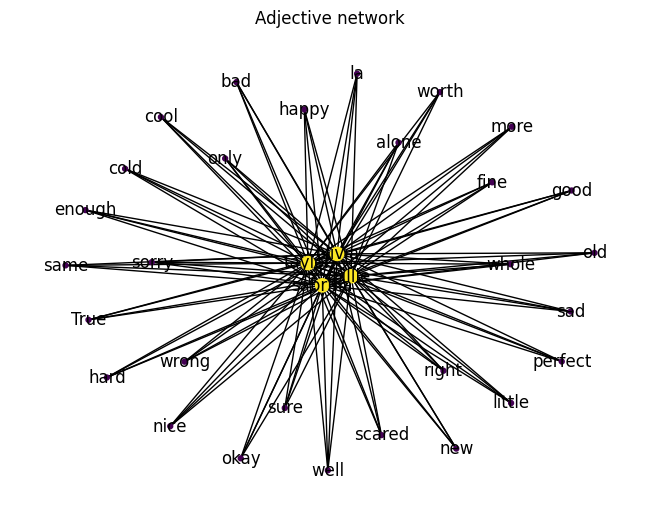

In [16]:
networkData = networkQuery(listLems, InputPath)   

# Create the network graph
G = nx.Graph()


# Iterate through the DataFrame and add nodes and edges
for i, row in networkData.iterrows():
    source = row[0]
    target = row[2]
    weight = row[3]
    G.add_node(source, shape='dot')
    G.add_node(target, shape='triangle')
    if target == "billie":
        colorEdge = "blue"
    elif target == "olivia": 
        colorEdge = "purple"
    elif target == "sabrina":
        colorEdge = "pink"
    elif target == "taylor":
        colorEdge = "red"
    else:
        colorEdge = "coral"
    # How to write Python if else conditions: https://www.w3schools.com/python/python_conditions.asp 
    G.add_edge(source, target, value=weight, title=weight, color=colorEdge)

# Calculate this network's centrality statistics
degree_centrality = nx.degree_centrality(G)
# print(degree_centrality)

closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
eccentricity = nx.eccentricity(G)
print(eccentricity)

# VISUALIZE THE NETWORKX NETWORK IN NETwORKX
# This particular network has low counts and values so networkx may be better suitednto display it.

# Create node size list based on closeness centrality
node_sizes = [v * 100 for v in degree_centrality.values()]
print(node_sizes)

# Generate node colors based on degree or eigenvector centrality
node_colorVals = [c * 20 for c in closeness_centrality.values()]

# Draw the graph
#npos = nx(G, scale=200, k=0.15, iterations=200, seed=578)  # Positions for all nodes
# nx.draw(G, with_labels=True, node_size=node_sizes, node_color=node_colorVals, pos=nx.fruchterman_reingold_layout(G), font_size=10)
# Fruchterman Reingold
nx.draw(G, with_labels=True, node_size=node_sizes, node_color=node_colorVals, pos=nx.fruchterman_reingold_layout(G))
plt.title("Adjective network")
plt.savefig("networkADJ.png")
plt.show()